In [335]:
import matplotlib
matplotlib.rcParams['xtick.labelsize']=20
matplotlib.rcParams['ytick.labelsize']=20
matplotlib.rcParams['font.size']=20
matplotlib.rcParams['lines.linewidth']=3
matplotlib.rcParams['legend.fancybox']=False
matplotlib.rcParams['legend.fontsize']=20
matplotlib.rcParams['legend.frameon']=False
matplotlib.rcParams['savefig.format']='pdf'

import sys
import string 
import pandas as pd
from operator import itemgetter
from collections import defaultdict
from collections import Counter
import numpy as np
import math
import random
from itertools import groupby
from scipy.spatial import distance
from operator import itemgetter
from numpy import einsum 
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
import scipy

%matplotlib inline

plt.interactive(True)


np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [510]:
filename = 'digits-embedding.csv'
df = pd.read_csv(filename, header=None)
df.columns = ['id', 'label', 'feature1', 'feature2']


features = df.loc[:, ['label', 'feature1','feature2']]
features_matrix = features.as_matrix()


In [ ]:
filename = 'digits-raw.csv'
df_raw = pd.read_csv(filename, header=None)
df_raw.head()

features_raw = df_raw.loc[:, 1:]
rawMatrix = features_raw.as_matrix()


In [518]:
#Randomly initiliaze ks.
def getKcentroids(featureNumbers, k, seed=123):
    random.seed(seed)
    kcentroids = np.random.uniform(low=-42, high=44, size=(k,featureNumbers))
    return kcentroids

#a) Calculate the distance of each data point to the centroid;
#b) Pick the index of the smallest distance of each data point;
#c) Return an array of the index showing which cluster the data belong to.
def assignClusters(inputData, kmeans):
    dist = scipy.spatial.distance.cdist(inputData, kmeans, 'euclidean')
    clusters = list(np.argmin(dist, axis = 1))
    return clusters

#update the k centroids based on the assigned cluster.
def updateKcentroids(inputData, clusters, k, seed=123):
    #combine the two into one matrix
    newMatrix = np.append(inputData, np.array(clusters)[:, None], 1) 
    #calculate the centroids group by the cluster labels.
    ux = np.unique(clusters)
    #lt = np.zeros(shape=(k,2))
    lt = np.zeros(shape=(k, inputData.shape[1]))
    for u in ux:
        #lt[u,:] = np.mean(newMatrix[newMatrix[:,2]==u, :2], axis=0)  
        lt[u,:] = np.mean(newMatrix[newMatrix[:,-1]==u, :-1], axis=0)  


    #Trivial case.
    for i in range(lt.shape[0]):
        if np.sum(lt[i,:]) == 0.0:
            lt[i,:] = getKcentroids(inputData.shape[1],1, seed) 
    return lt

#Implement Kmeans.
def kmeans(inputData, k, MAX_ITERATIONS=50, seed=123):
    
    #initialize k means
    means = getKcentroids(inputData.shape[1], k)
    
    #trackers
    iterations = 0
    
    while iterations <= MAX_ITERATIONS:
        iterations += 1
        
        #calculate the dist based on the updated means, assign each obs. into a cluster.
        clusters = assignClusters(inputData, means)
        
        #Update kmeans based on the current assignment.
        means = updateKcentroids(inputData, clusters, k, seed)
    
    return means, clusters

#evaluate the results using 
    #(1) within-cluster sum of squared distances;
    #(2) silhouette coefficient; 
    #(3) normalized mutual information gain (based on image labels).
def eval_wcss(inputData, kmeans, clusters):
    k = kmeans.shape[0]
    
    newMatrix = np.append(inputData, np.array(clusters)[:, None], 1)   
    wcss = 0
    
    for i in range(k):
        wcss += np.sum(np.power(newMatrix[newMatrix[:,-1]==i, :-1] - kmeans[i,:], 2))
        
    return wcss

def eval_silhouette(inputData, kmeans, clusters):
    k = kmeans.shape[0]
    dim = inputData.shape[0]
    
    dist = []
    cls = [] # cluster size
    
    A = 0
    
    for kl in np.unique(clusters):
        cli = np.where(clusters == kl)
        klcluster = inputData[cli,:][0]
        distl = scipy.spatial.distance.cdist(inputData, klcluster, 'euclidean')
        distmean = np.mean(distl, axis = 1)[:,None]
        cls.append(len(distl))
        dist.append(distmean)
        
    dist = np.concatenate(dist, axis=1)
    
    cll = np.array(clusters).reshape(dim,1) + 1
    kinv = 1/(1+np.array(range(k)))
    mask = np.kron(cll, kinv) - 1
    mask2 = mask + 1e9
    nx, ny = np.nonzero(mask)    
    mask[nx, ny] = 1
    mask2[nx, ny] = 1
    mask = 1 - mask
    A = np.array(einsum('ij,ij->i', dist, mask))[:,None] + 1e-9
    B = einsum('ij,ij->ij', dist, mask2)
    B = np.array(np.min(B, axis = 1))[:,None] + 1e-9
    C = np.max(np.concatenate([A, B], axis=1), axis=1)[:,None]
    S = (B-A)/C
    
    return np.mean(S)

#The input data is the dataframe. inputData = rawMatrix
def eval_NMI(inputData, kmeans, clusters):
    
    newMatrix = np.append(inputData, np.array(clusters)[:, None], 1)   
    
    info_gain = 0
    
    #compute the info. gain between clusters and class labels.
    p_cluster = np.bincount(clusters) / len(clusters)
    
    p_class = np.bincount(newMatrix[:,0].astype(int)) / newMatrix.shape[0]
    
    ux = np.unique(newMatrix[:,-1]).astype(int)
    ul = np.unique(newMatrix[:,0]).astype(int)
    
    for u in ux:
        temp_matrix = newMatrix[newMatrix[:,-1].astype(int) == u, :]
        uc = np.unique(temp_matrix[:,0]).astype(int)
        temp2 = np.bincount(temp_matrix[:,0].astype(int)) / newMatrix.shape[0]
        p_class_cluster = temp2[uc]

        temp = np.true_divide(p_class_cluster, p_cluster[u]*p_class[uc])
        
        info_gain += np.dot(p_class_cluster, np.log(temp))
        
    
    
    norm = -np.dot(p_cluster[ux], np.log(p_cluster[ux]))-np.dot(p_class[ul], np.log(p_class[ul]))

    NMI = info_gain / norm
    
    return NMI



In [165]:
def main():
    if len(sys.argv) < 2:
        print('usage: python nbc.py train.csv test.csv')
        print('exiting...')

    else:
        df = sys.argv[1]
        k = sys.argv[2]
        #modelIdx = sys.argv[3]
    
    df.columns = ['id', 'label', 'feature1', 'feature2']

    features = df.loc[:, ['label','feature1','feature2']]
    features_matrix = features.as_matrix()
    features_matrix1 = features_matrix[:,1:]
    
    means, clusters = kmeans(features_matrix1, k, MAX_ITERATIONS=50, seed=1)
    
    print("WC-SSD %.3f" % eval_wcss(features_matrix1, means, clusters))
    print("SC %.3f" % eval_silhouette(features_matrix1, means, clusters))
    print("NMI %.3f" % eval_NMI(features_matrix, kmeans, clusters))
    
    
main()


AttributeError: 'str' object has no attribute 'columns'

# A. Exploration


In [507]:
#Randomly pick N images from each digit group.
def random_digit_pick(inputData, N=1, keepLabel=False, seed=123):
    np.random.seed(seed)
    l = list()
    
    ux = np.unique(inputData[:,0]).astype(int)

    for u in ux:
        if not keepLabel:
            tempMatrix = inputData[inputData[:,0] == u, 1:]
        else:
            tempMatrix = inputData[inputData[:,0] == u, :]

        l.append(tempMatrix[np.random.choice(tempMatrix.shape[0], N, replace=False), :])
    
    return l

    
def print_image(inputList):
    fix,ax = plt.subplots(nrows = 2, ncols = 5,sharex = True, sharey = True,)
    ax = ax.flatten()
    for l in inputList:
        pixels = l.reshape((28,28))
        ax[i].imshow(pixels, cmap='gray')     
        
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()


def print_2D(inputData, N=1000, seed=123):
    np.random.seed(seed)
    marker_list = ['<','s','o','^','*','v','1','2','3','4']
    colors = ['lightblue','pink','aqua','c','lightyellow','y','k','lightskyblue','crimson','olive']
    
    newMatrix = inputData[np.random.choice(inputData.shape[0], N, replace=False), :]
    labels = np.unique(newMatrix[:,0]).astype(int)

    plt.figure(figsize=(10,6), dpi=80)


    for i in range(len(labels)):
        plt.title('2D Plot by Cluster Numbers (Sample Size=' + str(N) + ')', fontsize=20)
        plt.scatter(newMatrix[:,1], newMatrix[:,2], c=newMatrix[:,0], color=colors[i], marker = marker_list[i])

    plt.legend(labels,loc ='best')
    plt.show()

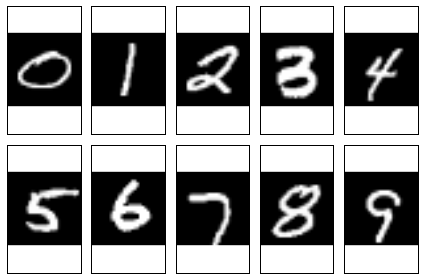

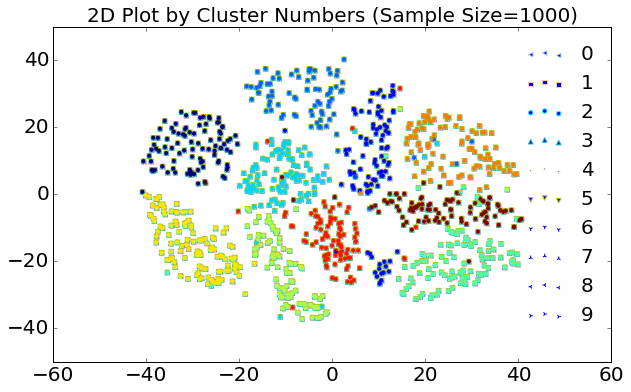

In [473]:
l = random_digit_pick(rawMatrix, 1)
print_image(l)
print_2D(features_matrix)
#features_matrix.shape

# B. Analysis of k-means.


# B1.


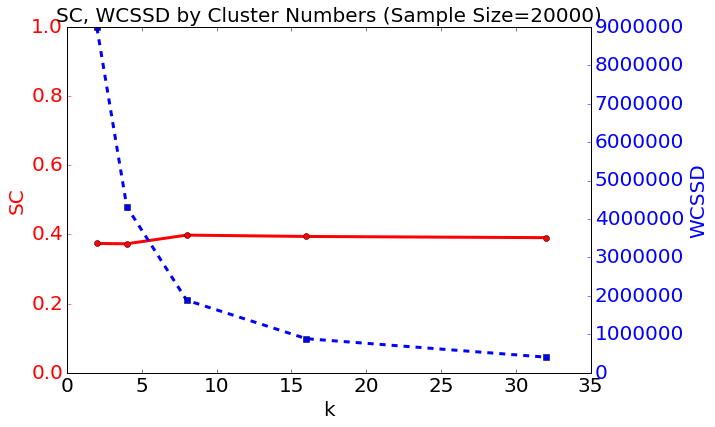

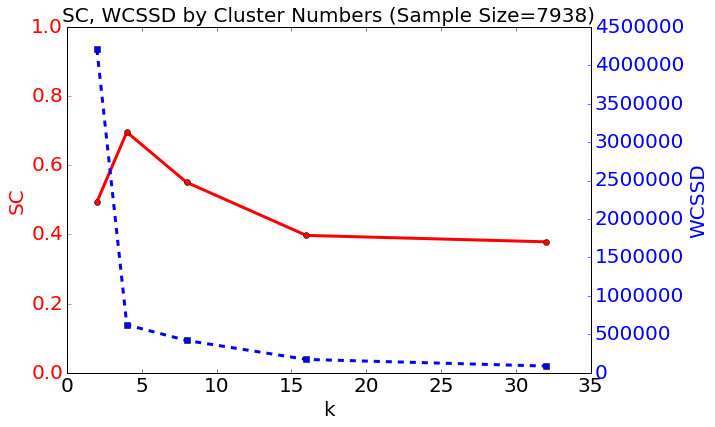

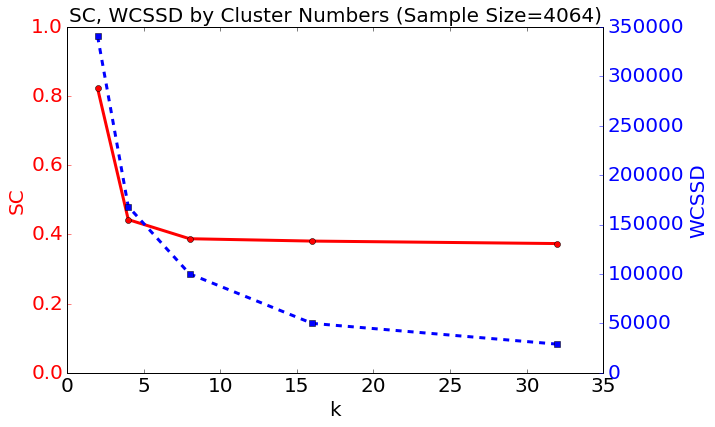

In [474]:
features = df.loc[:, ['label','feature1','feature2']]
features_matrix = features.as_matrix()
features_sub2 = features_matrix[features_matrix[:,0] == 2, :]
features_sub4 = features_matrix[features_matrix[:,0] == 4, :]
features_sub6 = features_matrix[features_matrix[:,0] == 6, :]
features_sub7 = features_matrix[features_matrix[:,0] == 7, :]

features_sub2467 = np.concatenate((features_sub2, features_sub4, features_sub6, features_sub7), axis=0)
features_sub67 = np.concatenate((features_sub6, features_sub7), axis=0)

#1. K ∈ [2,4,8,16,32] 

k = [2,4,8,16,32] 

datalist = [features_matrix[:,1:], features_sub2467[:,1:], features_sub67[:,1:]]


for l in datalist:
    sc = []
    wcssd = []
    distMatrix = get_distMatrix(l)
    for t in k:
        means, clusters = kmeans(l, t, MAX_ITERATIONS=50, seed=123)
        silhouette = eval_silhouette(l, means, clusters)
        wcss = eval_wcss(l, means, clusters)

        sc.append(silhouette)
        wcssd.append(wcss)


    fig, ax1 = plt.subplots(figsize=(10,6)) 
    plt.title('SC, WCSSD by Cluster Numbers (Sample Size=' + str(len(l)) + ')', fontsize=20)

    ax1.plot(k, sc, marker='o', linestyle='-', color='r', label='SC')
    ax1.set_xlabel('k', fontsize=20)
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('SC', color='r', fontsize=20)
    ax1.tick_params('y', colors='r')
    ax1.set_ylim([0,1])

    ax2 = ax1.twinx()
    ax2.plot(k, wcssd, marker='s', linestyle='--', color='b', label='WCSSD')
    ax2.set_ylabel('WCSSD', color='b', fontsize=20)
    ax2.tick_params('y', colors='b')

    fig.tight_layout()
    plt.show()
         

# B3. 


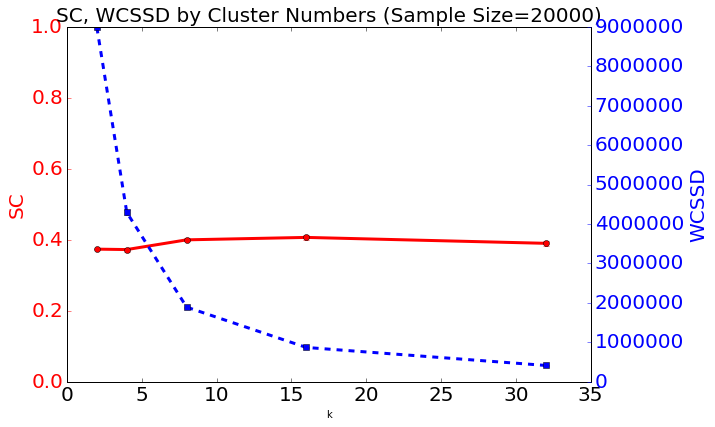

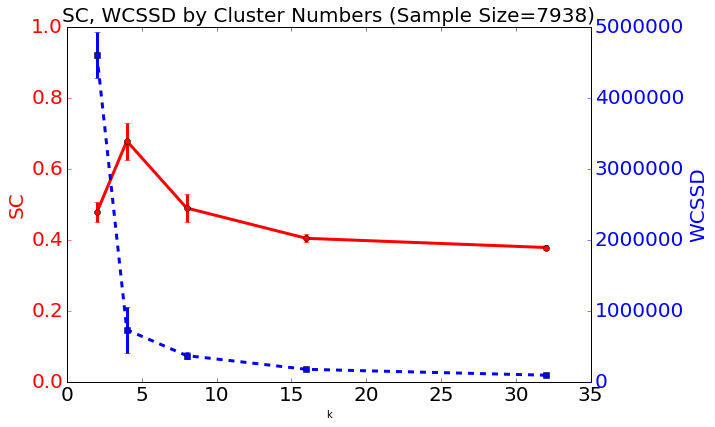

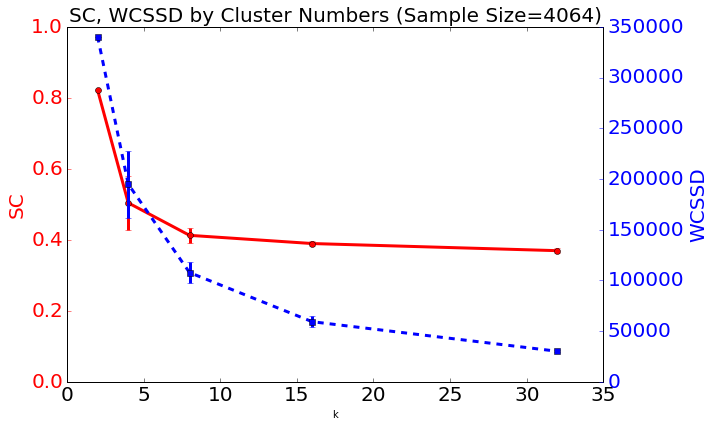

In [475]:
#2. Seed = [1, 2, 3, 123, 456, 4, 6, 789, 9, 223]
seed = [1, 2, 3, 123, 456, 4, 6, 789, 9, 223]

for l in datalist:
    sc_mean_list = []
    wcssd_mean_list = []
    sc_std_list = []
    wcssd_std_list = []
        
    for t in k:
        sc = []
        wcssd = []
        for s in seed:
            means, clusters = kmeans(l, t, MAX_ITERATIONS=50, seed=s)
            silhouette = eval_silhouette(l, means, clusters)
            wcss = eval_wcss(l, means, clusters)

            sc.append(silhouette)
            wcssd.append(wcss)

        sc_mean = np.mean(sc)
        wcssd_mean = np.mean(wcssd)

        sc_std = np.std(sc)
        wcssd_std = np.std(wcssd)

        sc_mean_list.append(sc_mean)
        wcssd_mean_list.append(wcssd_mean)

        sc_std_list.append(sc_std)
        wcssd_std_list.append(wcssd_std)

    fig, ax1 = plt.subplots(figsize=(10,6)) 
    plt.title('SC, WCSSD by Cluster Numbers (Sample Size=' + str(len(l)) + ')', fontsize=20)

    ax1.errorbar(k, sc_mean_list, sc_std_list, marker='o', linestyle='-', color='r', label='SC')
    ax1.set_xlabel('k')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('SC', color='r', fontsize=20)
    ax1.tick_params('y', colors='r')
    ax1.set_ylim([0,1])


    ax2 = ax1.twinx()
    plt.errorbar(k, wcssd_mean_list, wcssd_std_list, marker='s', linestyle='--', color='b', label='WCSSD')
    ax2.set_ylabel('WCSSD', color='b', fontsize=20)
    ax2.tick_params('y', colors='b')

    fig.tight_layout()
    plt.show()



# B4. 


NMI: 0.370607350229(sample size=20000)


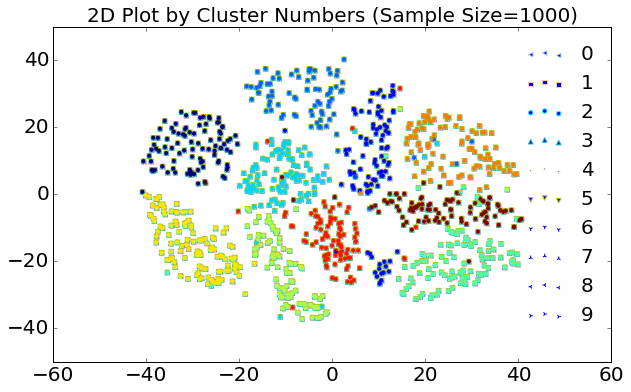

NMI: 0.45465341281(sample size=7938)


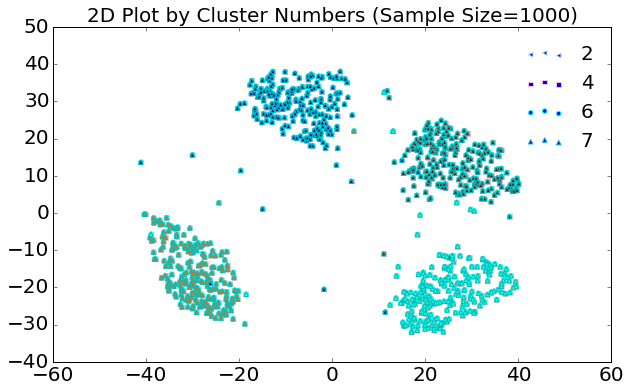

NMI: 0.327320174638(sample size=4064)


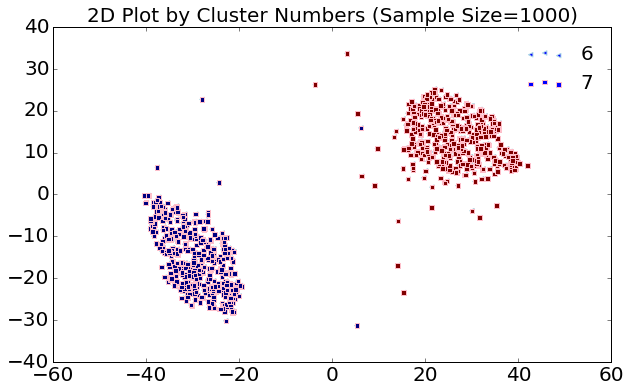

In [486]:
datalist2 = [features_matrix, features_sub2467, features_sub67]
k = [16, 4, 4]
i = 0
for l2 in datalist2:
    means, clusters = kmeans(l2[:,1:], k[i], MAX_ITERATIONS=50, seed=123)
    
    NMI = eval_NMI(l2, means, clusters) 
    print('NMI: '+str(NMI)+'(sample size='+str(l2.shape[0])+')')
    i+=1
    
    print_2D(l2, N=1000)

# C1-2. Hierarchical Clustering


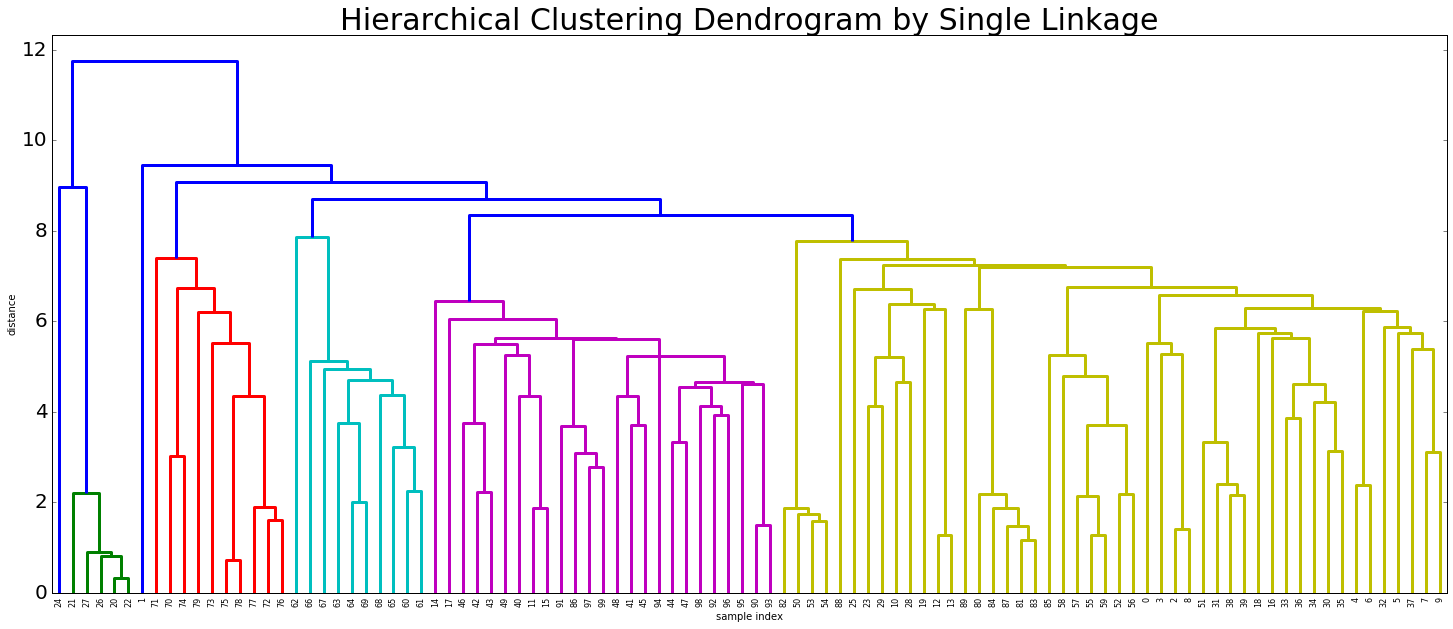

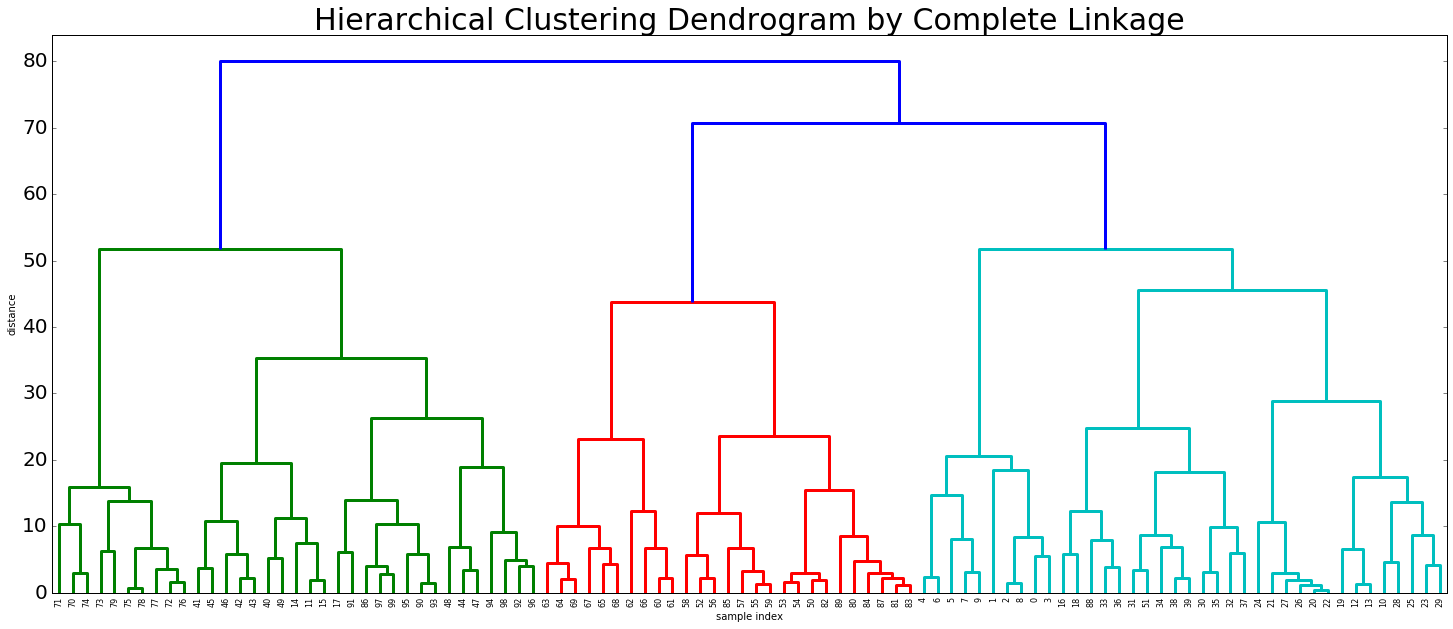

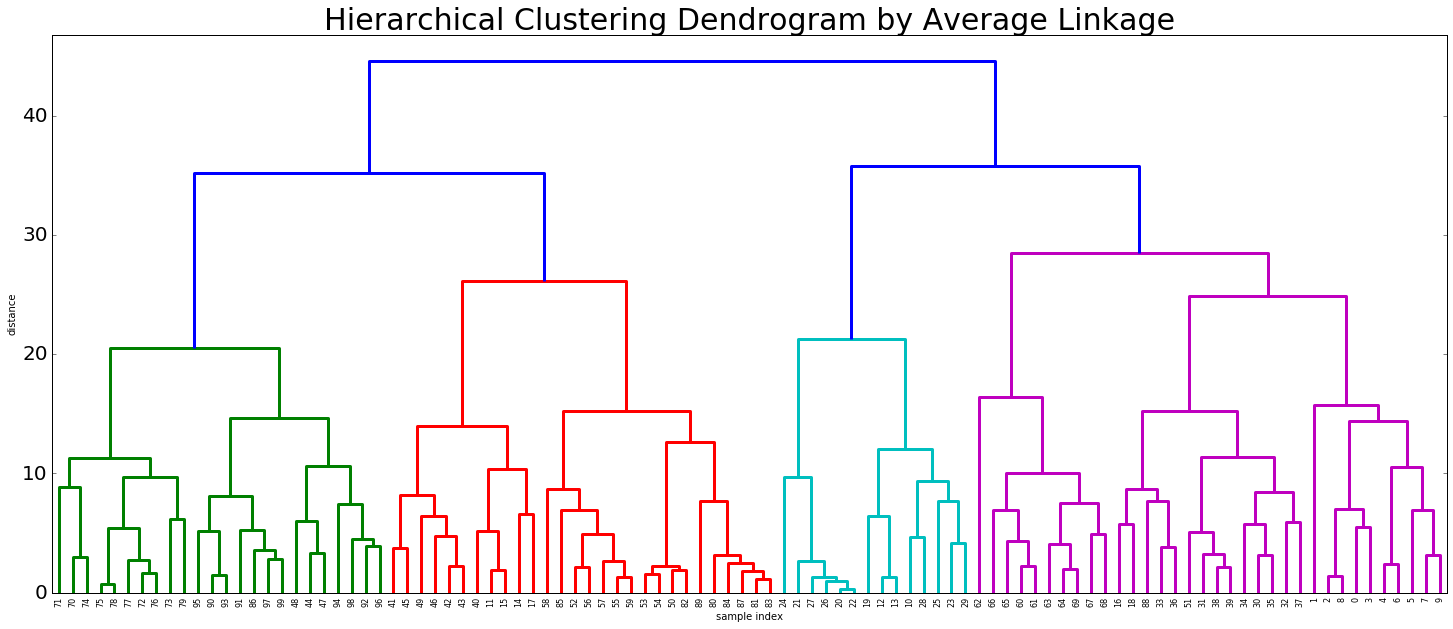

In [489]:
#Clustering using single linkage.
subsample = np.concatenate(random_digit_pick(features_matrix, 10, False, 123), axis=0)


# generate the linkage matrix
d = distance.pdist(subsample) 
Z = linkage(d, 'single')


# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram by Single Linkage', fontsize=30)
plt.xlabel('sample index')
#plt.xlabel(clusters)
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

# generate the linkage matrix
Y = linkage(d, 'complete')


# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram by Complete Linkage',  fontsize=30)
plt.xlabel('sample index')
#plt.xlabel(clusters)
plt.ylabel('distance')
dendrogram(
    Y,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

# generate the linkage matrix
X = linkage(subsample, 'average')


# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram by Average Linkage',  fontsize=30)
plt.xlabel('sample index')
#plt.xlabel(clusters)
plt.ylabel('distance')
dendrogram(
    X,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

# C3-1.


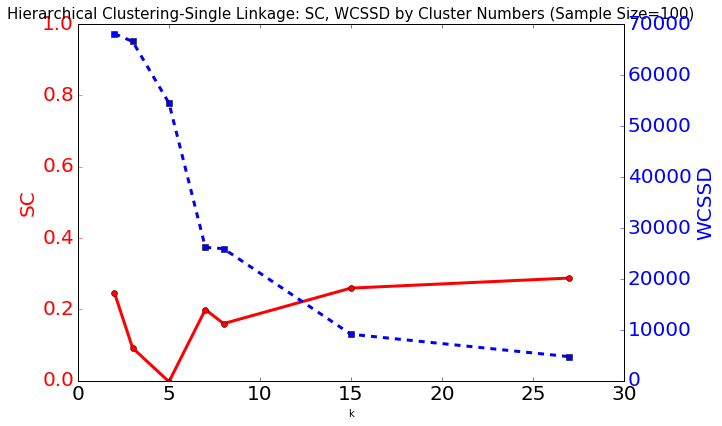

In [494]:
#For single linkage
k = [2, 3, 5, 7, 8, 15, 27]

sc = []
wcssd = []
subsample2 = np.concatenate(random_digit_pick(features_matrix, 10, True), axis=0)


for t in k:
    clusters = sch.fcluster(Z, t, criterion='maxclust') - 1
    means = updateKcentroids(subsample2[:,1:], clusters, t, 123)
    silhouette = eval_silhouette(subsample2[:,1:], means, clusters)
    wcss = eval_wcss(subsample2[:,1:], means, clusters)

    sc.append(silhouette)
    wcssd.append(wcss)


fig, ax1 = plt.subplots(figsize=(10,6)) 
plt.title('Hierarchical Clustering-Single Linkage: SC, WCSSD by Cluster Numbers (Sample Size=' + str(subsample2.shape[0]) + ')', fontsize=15)

ax1.plot(k, sc, marker='o', linestyle='-', color='r', label='SC')
ax1.set_xlabel('k')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('SC', color='r',  fontsize=20)
ax1.tick_params('y', colors='r')
ax1.set_ylim([0,1])

ax2 = ax1.twinx()
ax2.plot(k, wcssd, marker='s', linestyle='--', color='b', label='WCSSD')
ax2.set_ylabel('WCSSD', color='b',  fontsize=20)
ax2.tick_params('y', colors='b')

fig.tight_layout()
plt.show()

# C3-2.

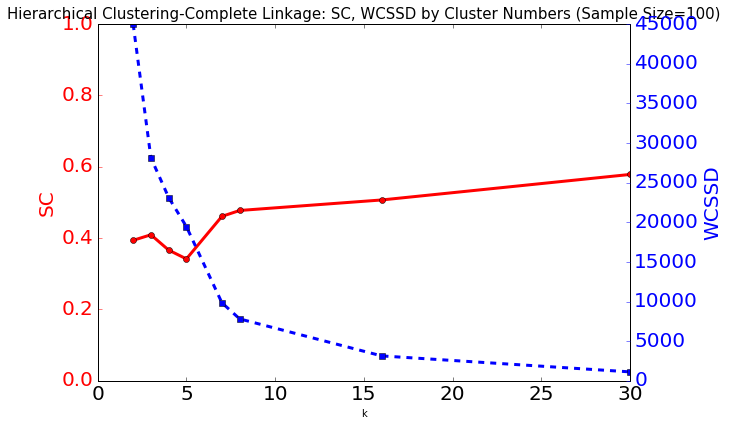

In [491]:
#For complete linkage
k = [2, 3, 4, 5, 7, 8, 16, 30]

sc = []
wcssd = []
subsample2 = np.concatenate(random_digit_pick(features_matrix, 10, True), axis=0)

distMatrix = get_distMatrix(subsample2[:,1:])


for t in k:
    clusters = sch.fcluster(Y, t, criterion='maxclust') - 1
    means = updateKcentroids(subsample2[:,1:], clusters, t, 123)
    silhouette = eval_silhouette(subsample2[:,1:], means, clusters)
    wcss = eval_wcss(subsample2[:,1:], means, clusters)

    sc.append(silhouette)
    wcssd.append(wcss)


fig, ax1 = plt.subplots(figsize=(10,6)) 
plt.title('Hierarchical Clustering-Complete Linkage: SC, WCSSD by Cluster Numbers (Sample Size=' + str(subsample2.shape[0]) + ')', fontsize=15)

ax1.plot(k, sc, marker='o', linestyle='-', color='r', label='SC')
ax1.set_xlabel('k')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('SC', color='r',  fontsize=20)
ax1.tick_params('y', colors='r')
ax1.set_ylim([0,1])

ax2 = ax1.twinx()
ax2.plot(k, wcssd, marker='s', linestyle='--', color='b', label='WCSSD')
ax2.set_ylabel('WCSSD', color='b',  fontsize=20)
ax2.tick_params('y', colors='b')

fig.tight_layout()
plt.show()

# C3-3. 

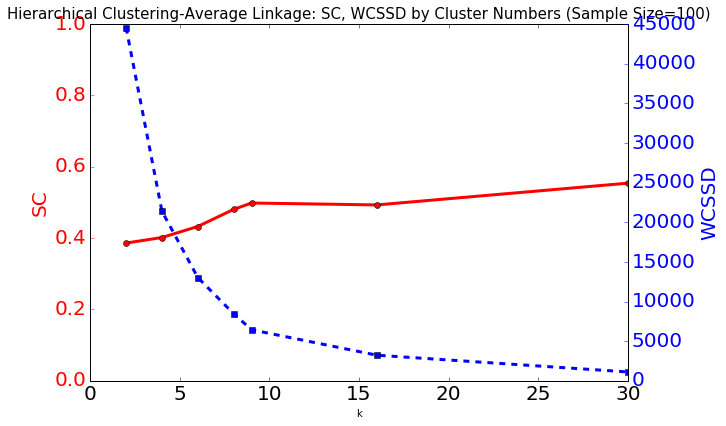

In [492]:
#For average linkage
k = [2, 4, 6, 8, 9, 16, 30]

sc = []
wcssd = []
subsample2 = np.concatenate(random_digit_pick(features_matrix, 10, True), axis=0)

distMatrix = get_distMatrix(subsample2[:,1:])

for t in k:
    clusters = sch.fcluster(X, t, criterion='maxclust') - 1
    means = updateKcentroids(subsample2[:,1:], clusters, t, 123)
    silhouette = eval_silhouette(subsample2[:,1:], means, clusters)
    wcss = eval_wcss(subsample2[:,1:], means, clusters)

    sc.append(silhouette)
    wcssd.append(wcss)


fig, ax1 = plt.subplots(figsize=(10,6)) 
plt.title('Hierarchical Clustering-Average Linkage: SC, WCSSD by Cluster Numbers (Sample Size=' + str(subsample2.shape[0]) + ')', fontsize=15)

ax1.plot(k, sc, marker='o', linestyle='-', color='r', label='SC')
ax1.set_xlabel('k')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('SC', color='r',  fontsize=20)
ax1.tick_params('y', colors='r')
ax1.set_ylim([0,1])

ax2 = ax1.twinx()
ax2.plot(k, wcssd, marker='s', linestyle='--', color='b', label='WCSSD')
ax2.set_ylabel('WCSSD', color='b',  fontsize=20)
ax2.tick_params('y', colors='b')

fig.tight_layout()
plt.show()

# C5.

Hierarchical Clustering-Single Linkage NMI: 0.368504509103(sample size=100)


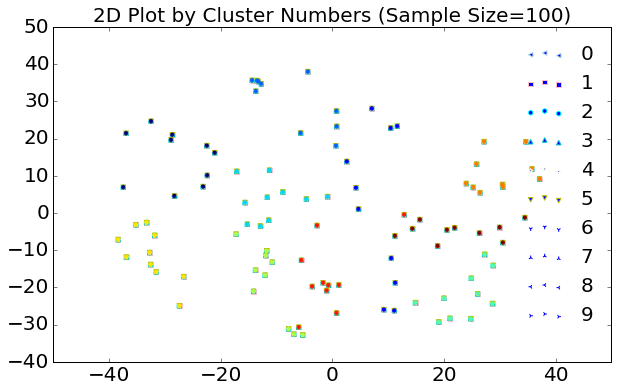

Hierarchical Clustering-Complete Linkage NMI: 0.406396982639(sample size=100)


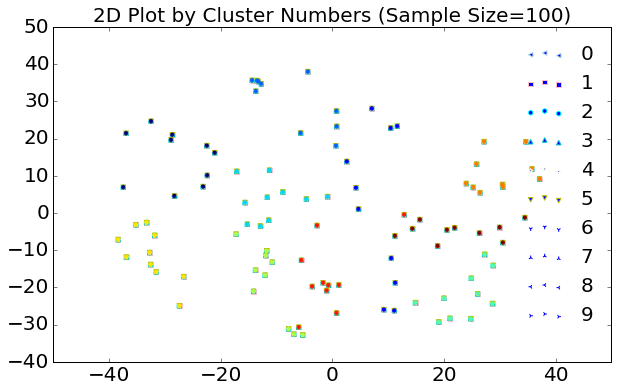

Hierarchical Clustering-Average Linkage NMI: 0.387099101576(sample size=100)


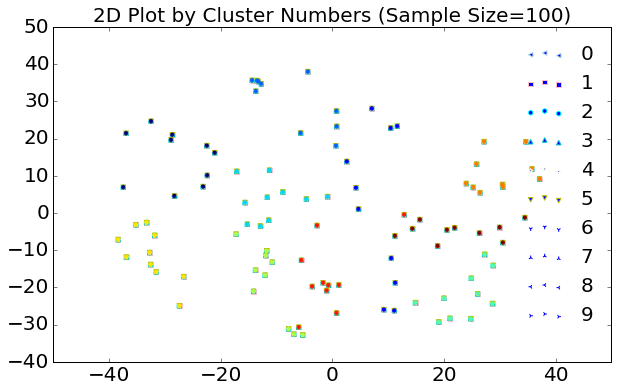

In [498]:
k_clusters = [15, 8, 8]


#Single linkage, k=15.
clusters = sch.fcluster(Z, 15, criterion='maxclust') - 1
means = updateKcentroids(subsample2[:,1:], clusters, 15, 123)

NMI = eval_NMI(subsample2, means, clusters) 
print('Hierarchical Clustering-Single Linkage NMI: '+str(NMI)+'(sample size='+str(subsample2.shape[0])+')')

print_2D(subsample2, N=100)

#Complete linkage, k=8.
clusters = sch.fcluster(Y, 8, criterion='maxclust') - 1
means = updateKcentroids(subsample2[:,1:], clusters, 8, 123)

NMI = eval_NMI(subsample2, means, clusters) 
print('Hierarchical Clustering-Complete Linkage NMI: '+str(NMI)+'(sample size='+str(subsample2.shape[0])+')')

print_2D(subsample2, N=100)

#Average linkage, k=8.
clusters = sch.fcluster(X, 8, criterion='maxclust') - 1
means = updateKcentroids(subsample2[:,1:], clusters, 8, 123)

NMI = eval_NMI(subsample2, means, clusters) 
print('Hierarchical Clustering-Average Linkage NMI: '+str(NMI)+'(sample size='+str(subsample2.shape[0])+')')

print_2D(subsample2, N=100)

# Bonus: PCA. 1.

In [504]:
#Remove label. Transform the dataset which has each feature per column. 

def dim_reduction(inputData):
    matrixPCA = inputData[:,1:]
    #Center the matrix by subtracting the mean of each feature.
    col_sums = matrixPCA.mean(axis=0, keepdims=True)
    new_matrix = matrixPCA - col_sums

    #Calculate 784*784 covariance matrix. 
    cov_mat = np.cov(np.transpose(new_matrix))

    #Perform the eigen decomposition on the covariance matrix.
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)


    # Make a list of (eigenvalue, eigenvector) tuples, and sort it descendingly
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs_sorted = sorted(eig_pairs,  key=lambda x: x[0], reverse=True)

    
    #Construct the projection matrix based on the top 10 eigen vectors.
    project_matrix = np.hstack((eig_pairs_sorted[0][1].reshape(784,1), 
                          eig_pairs_sorted[1][1].reshape(784,1),
                          eig_pairs_sorted[2][1].reshape(784,1),
                          eig_pairs_sorted[3][1].reshape(784,1),
                          eig_pairs_sorted[4][1].reshape(784,1),
                          eig_pairs_sorted[5][1].reshape(784,1),
                          eig_pairs_sorted[6][1].reshape(784,1),
                          eig_pairs_sorted[7][1].reshape(784,1),
                          eig_pairs_sorted[8][1].reshape(784,1),
                          eig_pairs_sorted[9][1].reshape(784,1)))
    reduced_matrix = np.real(new_matrix.dot(project_matrix))
    reduced_matrix2 = np.real(np.concatenate((inputData[:,0].reshape(inputData.shape[0],1), reduced_matrix[:,:2]), axis=1))
    reduced_matrix3 = np.real(np.concatenate((inputData[:,0].reshape(inputData.shape[0],1), reduced_matrix), axis=1))


    l = np.real([eig_pairs_sorted[0][1], 
          eig_pairs_sorted[1][1],
          eig_pairs_sorted[2][1],
          eig_pairs_sorted[3][1],
          eig_pairs_sorted[4][1],
          eig_pairs_sorted[5][1],
          eig_pairs_sorted[6][1],
          eig_pairs_sorted[7][1],
          eig_pairs_sorted[8][1],
          eig_pairs_sorted[9][1]])

    return reduced_matrix, l, reduced_matrix2, reduced_matrix3 

# Bonus 2. 

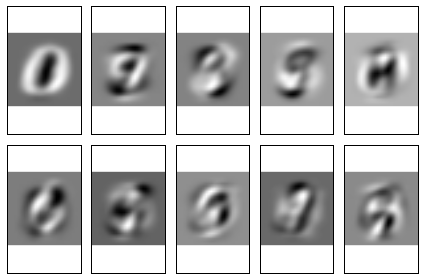

In [416]:
print_image(dim_reduction(rawMatrix)[1])

# Bonus 3.

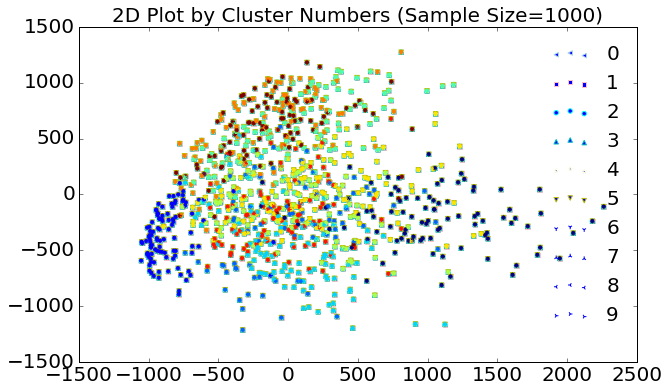

In [418]:
#3. 
print_2D(dim_reduction(rawMatrix)[2], N=1000)


# Bonus 4.

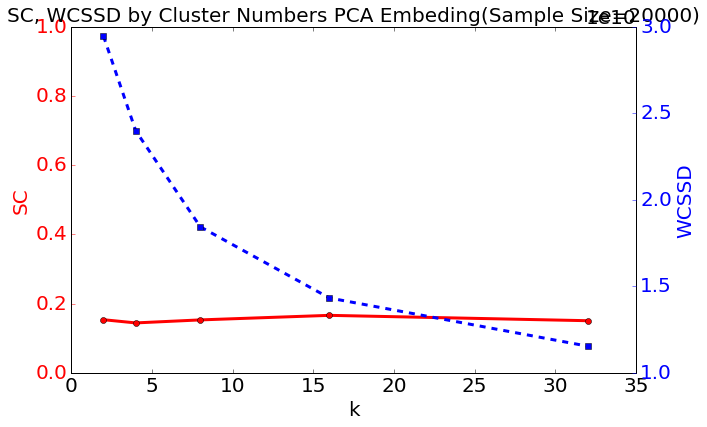

In [469]:
#4.
PCA_embed = np.real(np.concatenate((rawMatrix[:,0].reshape(20000,1), dim_reduction(rawMatrix)[0]), axis=1))


k = [2,4,8,16,32] 

sc = []
wcssd = []

for t in k:
    means, clusters = kmeans(PCA_embed[:,1:], t, MAX_ITERATIONS=50, seed=123)
    silhouette = eval_silhouette(PCA_embed[:,1:], means, clusters)
    wcss = eval_wcss(PCA_embed[:,1:], means, clusters)

    sc.append(silhouette)
    wcssd.append(wcss)


fig, ax1 = plt.subplots(figsize=(10,6)) 
plt.title('SC, WCSSD by Cluster Numbers PCA Embeding(Sample Size=' + str(PCA_embed.shape[0]) + ')', fontsize=20)

ax1.plot(k, sc, marker='o', linestyle='-', color='r', label='SC')
ax1.set_xlabel('k', fontsize=20)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('SC', color='r', fontsize=20)
ax1.tick_params('y', colors='r')
ax1.set_ylim([0,1])

ax2 = ax1.twinx()
ax2.plot(k, wcssd, marker='s', linestyle='--', color='b', label='WCSSD')
ax2.set_ylabel('WCSSD', color='b', fontsize=20)
ax2.tick_params('y', colors='b')

fig.tight_layout()
plt.show()


NMI: 0.255088332328(sample size=20000)


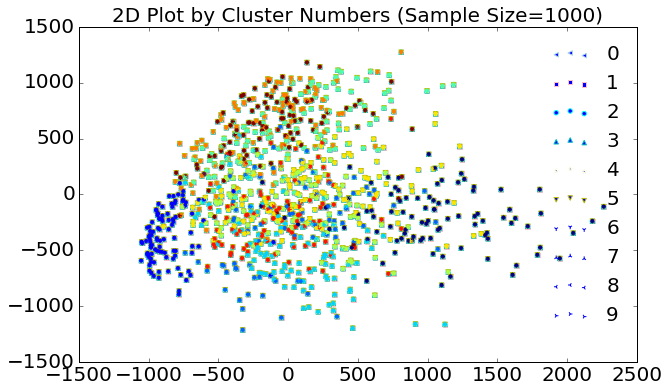

In [503]:
#Pick k= 16

means, clusters = kmeans(PCA_embed[:,1:], k=16, MAX_ITERATIONS=50, seed=123)

NMI = eval_NMI(PCA_embed, means, clusters) 
print('NMI: '+str(NMI)+'(sample size='+str(PCA_embed.shape[0])+')')

print_2D(PCA_embed, N=1000)

# Bonus 5.



(20000, 785)


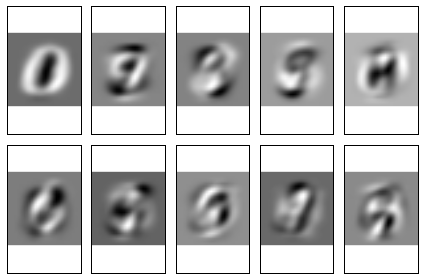

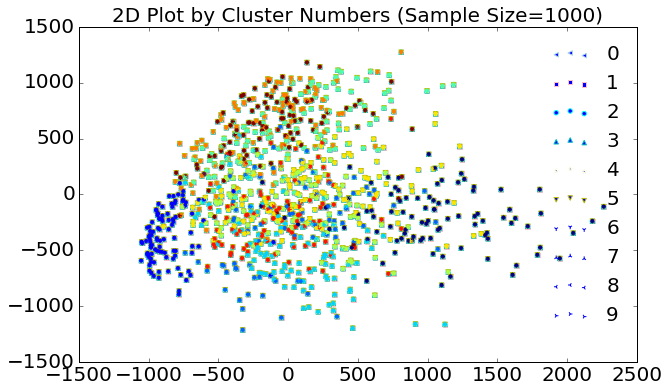

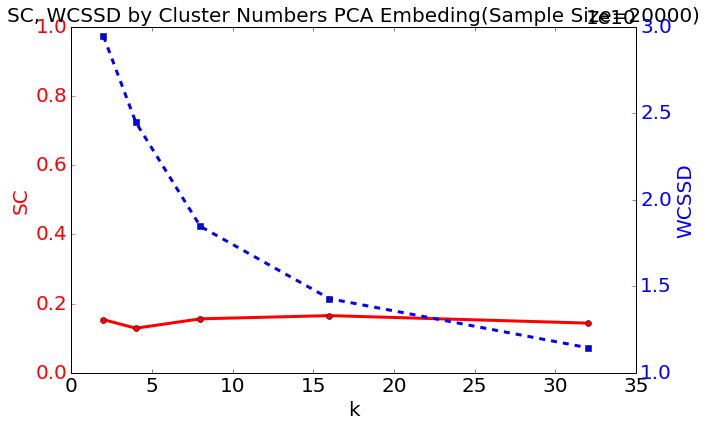

(7938, 785)


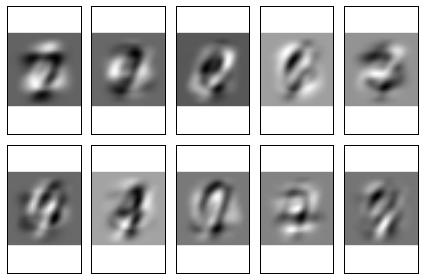

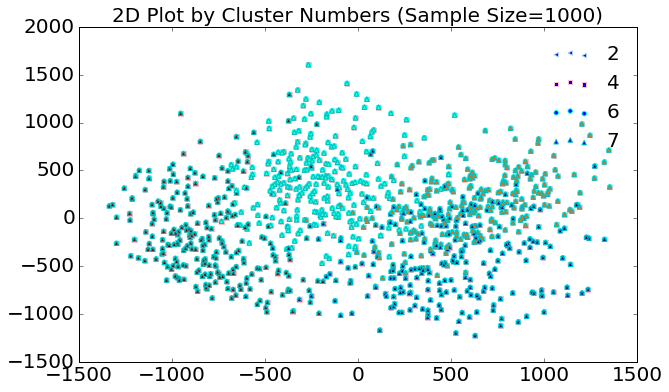

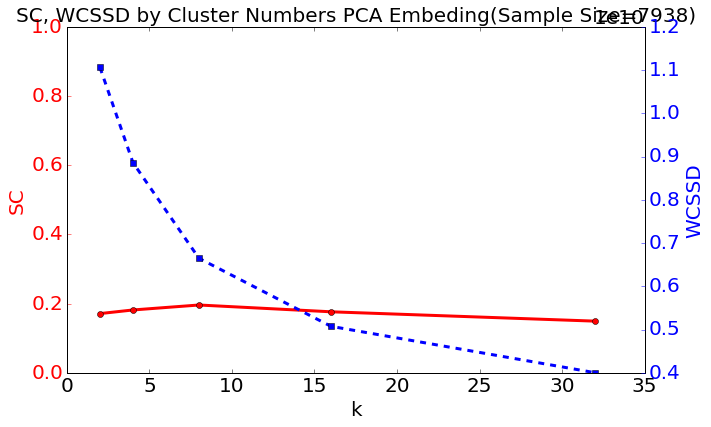

(4064, 785)


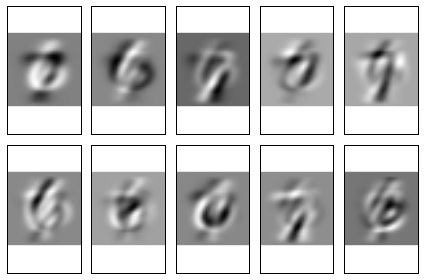

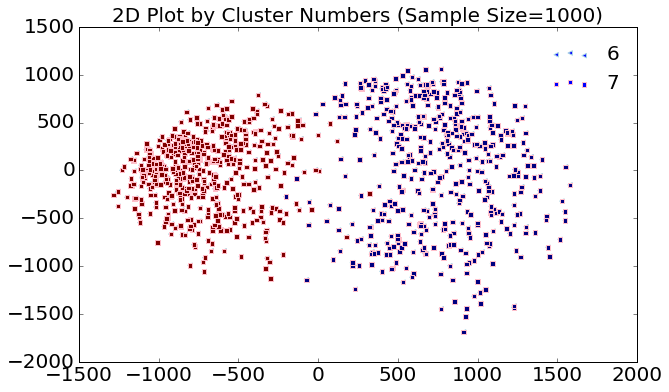

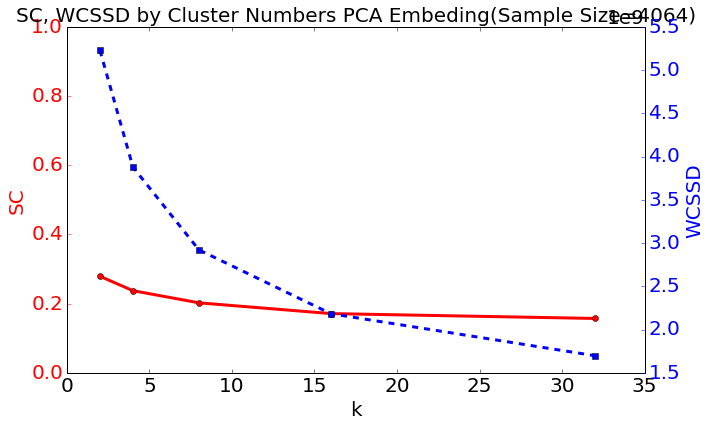

In [500]:
#5.
#First take subset on the raw data.
features_sub2 = rawMatrix[rawMatrix[:,0] == 2, :]
features_sub4 = rawMatrix[rawMatrix[:,0] == 4, :]
features_sub6 = rawMatrix[rawMatrix[:,0] == 6, :]
features_sub7 = rawMatrix[rawMatrix[:,0] == 7, :]

features_sub2467 = np.concatenate((features_sub2, features_sub4, features_sub6, features_sub7), axis=0)
features_sub67 = np.concatenate((features_sub6, features_sub7), axis=0)

datalist = [rawMatrix, features_sub2467, features_sub67]

#For each subset, repeat step 1 - 4. 


k = [2,4,8,16,32] 


for l in datalist:
    print(l.shape)
    #step 1-3.
    reduced_matrix, lt, reduced_matrix2, reduced_matrix3 = dim_reduction(l)
    print_image(lt)
    print_2D(reduced_matrix2, N=1000)
    
    #step 4.
    sc = []
    wcssd = []
    for t in k:
        means, clusters = kmeans(reduced_matrix, t, MAX_ITERATIONS=50, seed=1)
        silhouette = eval_silhouette(reduced_matrix, means, clusters)
        wcss = eval_wcss(reduced_matrix, means, clusters)

        sc.append(silhouette)
        wcssd.append(wcss)


    fig, ax1 = plt.subplots(figsize=(10,6)) 
    plt.title('SC, WCSSD by Cluster Numbers PCA Embeding(Sample Size=' + str(len(l)) + ')', fontsize=20)

    ax1.plot(k, sc, marker='o', linestyle='-', color='r', label='SC')
    ax1.set_xlabel('k', fontsize=20)
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('SC', color='r', fontsize=20)
    ax1.tick_params('y', colors='r')
    ax1.set_ylim([0,1])

    ax2 = ax1.twinx()
    ax2.plot(k, wcssd, marker='s', linestyle='--', color='b', label='WCSSD')
    ax2.set_ylabel('WCSSD', color='b', fontsize=20)
    ax2.tick_params('y', colors='b')

    fig.tight_layout()
    plt.show()
    
    #now get the k = 16, 8, 8. 
    


    
    

PCA Embedding NMI: 0.255088332328(sample size=20000)


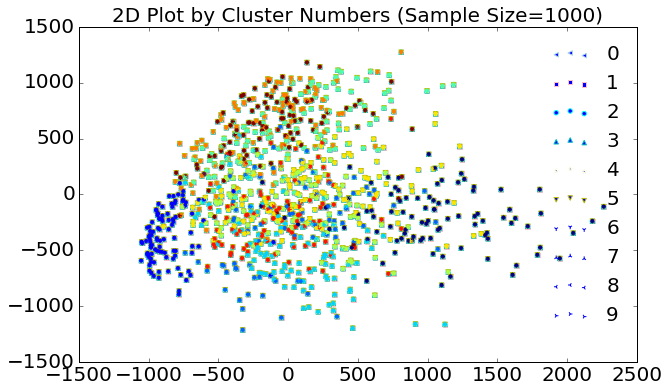

PCA Embedding NMI: 0.294626814202(sample size=7938)


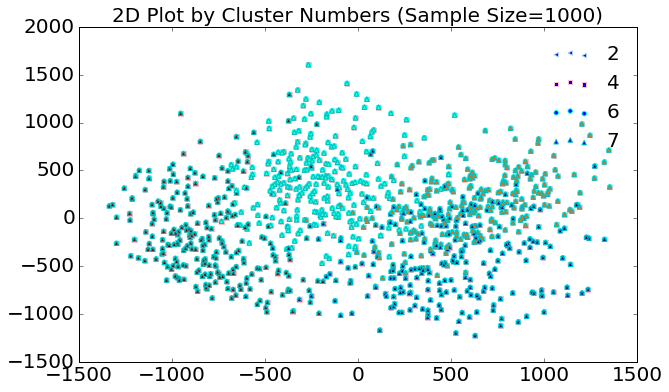

PCA Embedding NMI: 0.242233772737(sample size=4064)


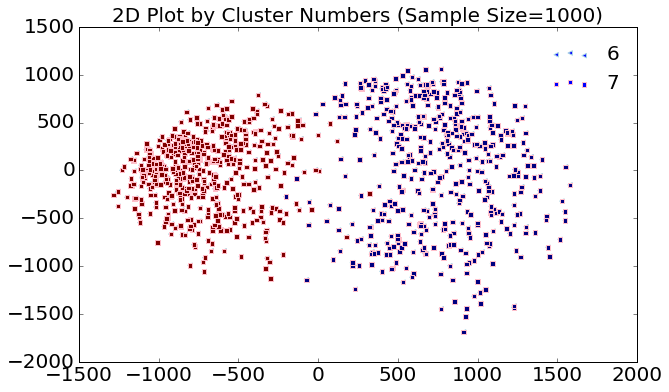

In [506]:
#reduced_matrix, lt, reduced_matrix2 = dim_reduction(features_sub67)
#Now get k = 16, 8, 8
k = [16, 8, 8]

i=0
for l in datalist:
    #step 1-3.
    reduced_matrix, lt, reduced_matrix2, reduced_matrix3 = dim_reduction(l)
    
    means, clusters = kmeans(reduced_matrix, k[i], MAX_ITERATIONS=50, seed=123)

    NMI = eval_NMI(reduced_matrix3, means, clusters) 
    print('PCA Embedding NMI: '+str(NMI)+'(sample size='+str(reduced_matrix3.shape[0])+')')
    
    print_2D(reduced_matrix3, N=1000)
    i+=1
